In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from dotenv import load_dotenv

In [2]:
def convert_to_mel_spectrogram(audio, sr, n_fft, hop_length, n_mels):
    if audio is None:
        return None
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels, fmax=sr / 2)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [3]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
hop_length = int(os.getenv('hop_length'))
n_mels = int(os.getenv('n_mels'))
n_fft = int(os.getenv('n_fft'))

In [4]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            target_sample_rate = sr
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [5]:
# 讀取分割後的音訊片段
normal_segments = load_segmented_files('output')
# 打亂 mel_spectrograms_normal 列表
np.random.shuffle(normal_segments)

100%|██████████| 1110/1110 [00:00<00:00, 1769.01it/s]


In [6]:
mel_spectrograms_normal = [convert_to_mel_spectrogram(audio[0], sample_rate, n_fft, hop_length, n_mels) for audio in tqdm(normal_segments)]

100%|██████████| 1110/1110 [00:08<00:00, 124.45it/s]


In [7]:
def plot_mel_spectrogram(mel_spectrogram, sr, filename:str = None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram of {filename}')
    plt.savefig(f'{filename}_mel_spectrogram.png')
    plt.show()

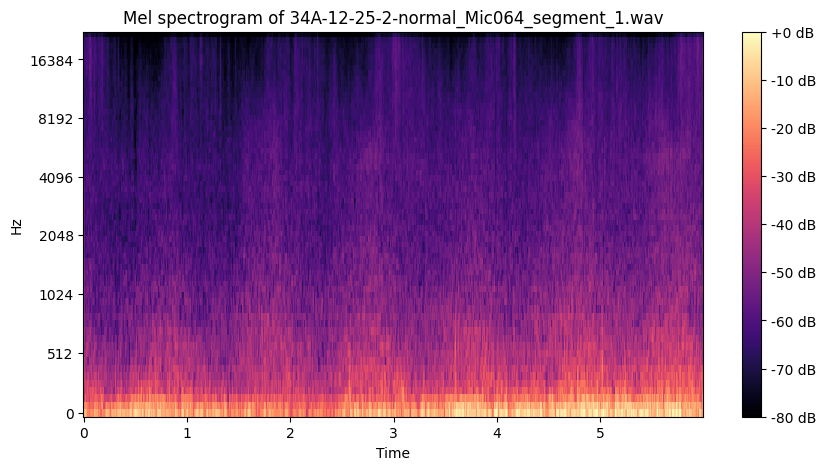

In [8]:
plot_mel_spectrogram(mel_spectrograms_normal[0], sample_rate, f'{normal_segments[0][1]}')

# Spilt Dataset to training and testing

In [9]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms_normal)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (710, 64, 1034)
驗證集數據形狀: (178, 64, 1034)
測試集數據形狀: (222, 64, 1034)


# 調整數據的形狀

In [10]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (710, 64, 1034, 1)
驗證集數據形狀: (178, 64, 1034, 1)
測試集數據形狀: (222, 64, 1034, 1)


# 創建 CNN Autoencoder 模型

In [11]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, \
    BatchNormalization
from tensorflow.keras.regularizers import l2


def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[0]
    input_width = input_shape[1]
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Flatten and Dense layers at bottleneck
    x = Flatten()(encoded)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(encoded.shape[1] * encoded.shape[2] * encoded.shape[3], activation='relu')(x)
    x = Reshape((encoded.shape[1], encoded.shape[2], encoded.shape[3]))(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    
    # Ensure the output has the same size as input
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :input_height, :input_width, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [12]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1034, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 1034, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 517, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 517, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 259, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 259, 32)       18464 

In [13]:
def plot_model(autoencoder):
    from tensorflow.keras.utils import plot_model
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    
plot_model(autoencoder)

In [14]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
# 設定初始學習率
initial_learning_rate = 0.0001

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)

def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mse_loss + mae_loss


# 編譯模型
autoencoder.compile(optimizer=optimizer, loss=combined_loss)

# 訓練模型

In [15]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
# 定義學習率調整策略
history = autoencoder.fit(train_data, train_data,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[early_stopping],
                verbose=2)

Epoch 1/200
23/23 - 10s - loss: 0.4808 - val_loss: 0.4732 - 10s/epoch - 425ms/step
Epoch 2/200
23/23 - 2s - loss: 0.3870 - val_loss: 0.4458 - 2s/epoch - 95ms/step
Epoch 3/200
23/23 - 2s - loss: 0.3342 - val_loss: 0.4326 - 2s/epoch - 97ms/step
Epoch 4/200
23/23 - 2s - loss: 0.3040 - val_loss: 0.4221 - 2s/epoch - 98ms/step
Epoch 5/200
23/23 - 2s - loss: 0.2835 - val_loss: 0.3969 - 2s/epoch - 98ms/step
Epoch 6/200
23/23 - 2s - loss: 0.2641 - val_loss: 0.3814 - 2s/epoch - 96ms/step
Epoch 7/200
23/23 - 2s - loss: 0.2461 - val_loss: 0.3605 - 2s/epoch - 97ms/step
Epoch 8/200
23/23 - 2s - loss: 0.2288 - val_loss: 0.3356 - 2s/epoch - 98ms/step
Epoch 9/200
23/23 - 2s - loss: 0.2201 - val_loss: 0.3208 - 2s/epoch - 96ms/step
Epoch 10/200
23/23 - 2s - loss: 0.2085 - val_loss: 0.3029 - 2s/epoch - 97ms/step
Epoch 11/200
23/23 - 2s - loss: 0.2006 - val_loss: 0.2916 - 2s/epoch - 96ms/step
Epoch 12/200
23/23 - 2s - loss: 0.1926 - val_loss: 0.2779 - 2s/epoch - 98ms/step
Epoch 13/200
23/23 - 2s - loss: 0.

# 評估模型

In [27]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

6/6 [==============================] - 0s 23ms/step - loss: 0.0482
Test loss: 0.04818963631987572


# 繪製訓練過程

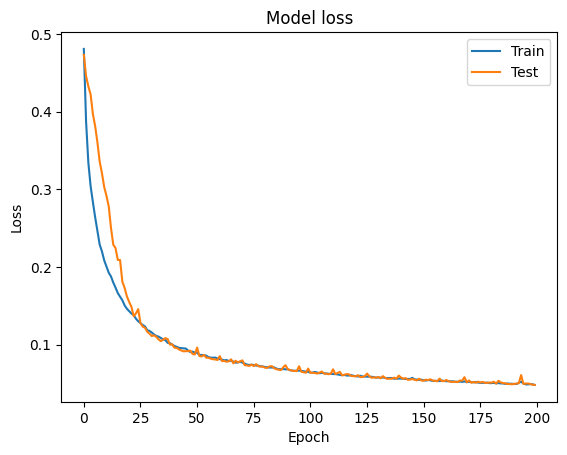

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

# 儲存模型

In [29]:
autoencoder.save('autoencoder.h5')

# 使用測試集數據進行預測

In [30]:
def calculate_reconstruction_error(original, reconstructed):
    # 如果只有單個樣本，確保數據是 4D
    if len(original.shape) == 3:
        original = np.expand_dims(original, axis=0)
        reconstructed = np.expand_dims(reconstructed, axis=0)
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))

In [31]:
# 計算每個樣本的重建損失
reconstructed_data = autoencoder.predict(train_data)
reconstruction_errors = calculate_reconstruction_error(train_data, reconstructed_data)

# 設定一個閾值來判斷異常
threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
print(f'Threshold: {threshold}')

23/23 [==============================] - 1s 28ms/step
Threshold: 0.002671868074685335


In [32]:
# 測試數據集上的重建
reconstructed_test_data = autoencoder.predict(test_data)

# 計算測試數據集上的重建誤差
test_reconstruction_errors = calculate_reconstruction_error(test_data, reconstructed_test_data)

# 判斷異常樣本
anomalies = test_reconstruction_errors > threshold
normal = test_reconstruction_errors <= threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# 可視化一些異常樣本
anomalous_data = test_data[anomalies]
anomalous_reconstructed_data = reconstructed_test_data[anomalies]

7/7 [==============================] - 0s 22ms/step
Number of anomalies detected: 12


In [33]:
# 測試單個樣本的重建誤差
error = calculate_reconstruction_error(test_data[0], reconstructed_test_data[0])[0]

In [34]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, threshold, loss, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    # plot mse if mse in red if mse > mse_threshold
    plt.text(0, 0, f'loss: {loss}', fontsize=12, color='red' if loss > threshold else 'black', backgroundcolor='white')
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

In [35]:
anomalies_index = np.where(anomalies)[0]
for i in tqdm(anomalies_index):
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', 
                    threshold=threshold, loss=test_reconstruction_errors[i],
                    output_name=f'images/reconstruct_anomaly/anomaly_{i}', save_only=True)

In [36]:
normal_index = np.where(normal)[0]
for i in tqdm(normal_index):
    loss = calculate_reconstruction_error(test_data[i], reconstructed_test_data[i])
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', threshold=threshold, loss=loss, output_name=f'images/reconstruct_normal/normal_{i}', save_only=True)

100%|██████████| 210/210 [01:16<00:00,  2.74it/s]


計算重建失敗的數量

In [25]:
print(f'Failed reconstruction count is {len(anomalies_index)}, total test data is {len(test_data)}')
print(f'Failed reconstruction rate is {len(anomalies_index) / len(test_data) * 100}%')
print(f'Success reconstruction rate is {100 - len(anomalies_index) / len(test_data) * 100}%')


Failed reconstruction count is 12, total test data is 222
Failed reconstruction rate is 5.405405405405405%
Success reconstruction rate is 94.5945945945946%
